# Aug 28, 2024: model comparison: total evidence

In [1]:
import csv
import os
import sys
import numpy as np
import pandas as pd
import scipy as sp 
import dill as pickle 
from os.path import join as pjoin
from itertools import product
from tqdm import tqdm
from copy import deepcopy
from pathlib import Path
import subprocess
from scipy import sparse, stats
from multiprocessing import Pool
import glob
import random

import arviz as az

from itertools import product, combinations
import multiprocessing as mp
from functools import partial

# networks
import graph_tool.all as gt

# plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.cm import rainbow
from matplotlib.patches import Rectangle

plt.rcParamsDefault['font.family'] = "sans-serif"
plt.rcParamsDefault['font.sans-serif'] = "Arial"
plt.rcParams['font.size'] = 14
plt.rcParams["errorbar.capsize"] = 0.5

import cmasher as cmr  # CITE ITS PAPER IN YOUR MANUSCRIPT
import colorcet as cc

# ignore user warnings
import warnings
warnings.filterwarnings("ignore") #, category=UserWarning)

In [2]:
class ARGS():
    pass

args = ARGS()

args.SEED = 100

def set_seed(args):
    gt.seed_rng(args.SEED)
    np.random.seed(args.SEED)

set_seed(args)

In [3]:
args.type = 'spatial'
args.roi_size = 225
args.maintain_symmetry = True
args.brain_div = 'whl'
args.num_rois = 162

PARC_DESC = (
    f'type-{args.type}'
    f'_size-{args.roi_size}'
    f'_symm-{args.maintain_symmetry}'
    f'_braindiv-{args.brain_div}'
    f'_nrois-{args.num_rois}'
)

In [4]:
args.GRAPH_DEF = f'constructed'
args.GRAPH_METHOD = f'pearson-corr'
args.THRESHOLDING = f'positive'
args.EDGE_DEF = f'binary'
args.EDGE_DENSITY = 15
args.LAYER_DEF = f'individual'
args.DATA_UNIT = f'ses'

BASE_path = f'{os.environ["HOME"]}/mouse_dataset/roi_results_v2'
ROI_path = f'{BASE_path}/{PARC_DESC}'
TS_path = f'{ROI_path}/runwise_timeseries'
ROI_RESULTS_path = (
    f'{ROI_path}'
    f'/graph-{args.GRAPH_DEF}/method-{args.GRAPH_METHOD}'
    f'/threshold-{args.THRESHOLDING}/edge-{args.EDGE_DEF}/density-{args.EDGE_DENSITY}'
    f'/layer-{args.LAYER_DEF}/unit-{args.DATA_UNIT}'
)
GRAPH_path = f'{ROI_RESULTS_path}/graphs'
os.system(f'mkdir -p {GRAPH_path}')
SBM_path = f'{ROI_RESULTS_path}/model-fits'
os.system(f'mkdir -p {SBM_path}')
ESTIM_path = f'{ROI_RESULTS_path}/estimates'
os.system(f'mkdir -p {ESTIM_path}/individual')
os.system(f'mkdir -p {ESTIM_path}/group')

0

In [5]:
def get_significance(pvalue, correction_factor):
    if pvalue <= 0.0001 / correction_factor:
        return "****"
    elif pvalue <= 0.001 / correction_factor:
        return "***"
    elif pvalue <= 0.01 / correction_factor:
        return "**"
    elif pvalue <= 0.05 / correction_factor:
        return "*"
    return "ns"

def plot_model_evidences(args, ax, fits_df, P):
    def get_label(names, idx):
        return '_'.join(map(
            lambda x: '-'.join(x), 
            zip(*[list(names), idx])
        ))
    x = np.arange(len(fits_df.columns))
    colors = ['tab:grey', 'tab:blue', 'tab:orange', 'tab:purple']
    used_labels = []
    for idx, row in fits_df.iterrows():
        label = get_label(fits_df.index.names[1:2], idx[1:2])
        if label in used_labels: label = None
        else: used_labels += [label]
        x_jit = x + np.random.normal(0, 0.0, len(x))
        ax.plot(x_jit, row.values, '-', color='grey', alpha=0.3, linewidth=0.5)
        ax.scatter(
            x_jit, row.values, 
            s=25, 
            color=colors[int(idx[1])], 
            marker='.', 
            linewidths=8, 
            label=label,
        )
    ax.legend(title='session', loc='lower right')
    ax.set_xticks(np.arange(len(fits_df.columns)), fits_df.columns)
    ax.set(
        title=f'sub-{sub}',
        ylabel='total evidence, log $P(A | M)$', 
        xlabel='model class, $M$',
    )
    ax.grid(True)

    correction_factor = P.shape[0] * (P.shape[0]-1) / 2
    y_min, y_max = ax.get_ylim()
    delta = (y_max - y_min)
    for i in x[:-1]:
        ax.text(i+0.5, y_max+0.05*delta, f'{get_significance(P[i, i+1], correction_factor)}', ha='center', va='bottom')
    
    ax.set_ylim(y_min, y_max + 0.15*delta)
    return ax


def plot_matrix(args, ax, M, P, sbms, title):
    sns.heatmap(
        M, 
        ax=ax,
        square=True,
        cmap=sns.diverging_palette(250, 30, l=65, center="dark", as_cmap=True),
        annot=True,
        fmt='.1f',
    )
    ax.set_xticks(ticks=np.arange(len(sbms))+0.5, labels=sbms, rotation=45)
    ax.set_yticks(ticks=np.arange(len(sbms))+0.5, labels=sbms, rotation=0)
    ax.set(title=title)

    mult_comp_corr = M.shape[0] * (M.shape[0]-1) / 2
    for i, j in product(range(P.shape[0]), range(P.shape[1])):
        if P[i, j] > 0.005 / mult_comp_corr:
            ax.add_patch(Rectangle((i, j), 1, 1, fill=False, edgecolor='tab:red', lw=3))
    return ax

In [6]:
def model_comparison(args, sub):
    sub = f'SLC{sub:02d}'
    files = sorted(glob.glob(f'{SBM_path}/sub-{sub}*/*/*/desc-evidence.pkl', recursive=True))

    dfs = []
    for file in tqdm(files): 
        with open(file, 'rb') as f:
            L = pickle.load(f)
        fs = file.split('/')

        df = pd.DataFrame({})

        for i in [-4, -2, -3]:
            for D in fs[i].split('_'):
                ds = D.split('-')
                d = '-'.join(ds[1:])
                df[ds[0]] = [d if d != '-a' else 'a']
        df['L'] = L
        dfs += [df]
    dfs = pd.concat(dfs).reset_index(drop=True)
    # dfs

    cols = list(dfs.columns)
    index = cols[:cols.index('sbm')]
    fits_df = pd.pivot(
        data=dfs,
        index=cols[:cols.index('sbm')],
        columns='sbm',
    )['L']
    # fits_df

    Cs = list(fits_df.columns)
    cols_reordered = stats.mode(fits_df.apply(np.argsort, axis=1).to_numpy()).mode
    cols_reordered = [Cs[c] for c in cols_reordered]
    cols_reordered
    fits_df = pd.DataFrame(
        data=fits_df,
        columns=cols_reordered,
    )
    display(fits_df)

    sbms = fits_df.columns.to_list()
    S = np.zeros((len(sbms), len(sbms)))
    P = np.zeros_like(S)
    for col1, col2 in product(range(len(sbms)), range(len(sbms))):
        a = fits_df[sbms[col1]]
        b = fits_df[sbms[col2]]
        res = stats.ttest_rel(a, b, nan_policy='omit')
        S[col1, col2] = res.statistic
        P[col1, col2] = res.pvalue

    fig = plt.figure(figsize=(12, 10))
    fig.subplots_adjust(hspace=0.33)
    gs = fig.add_gridspec(2, 2, height_ratios=[1, 1])

    ax = fig.add_subplot(gs[0, :])  # Top subplot spanning both columns
    ax = plot_model_evidences(args, ax, fits_df, P)
    print(ax.get_ylim())

    ax = fig.add_subplot(gs[1, 0])  # Bottom-left subplot
    ax = plot_matrix(args, ax, S, P, sbms, title=f'difference [row] - [col]')

    ax = fig.add_subplot(gs[1, 1])  # Bottom-right subplot
    ax = plot_matrix(args, ax, P, P, sbms, title=f'p value')

    fig_file = f'{ESTIM_path}/individual/sub-{sub}/model-comparison'
    os.system(f'mkdir -p {fig_file}')
    fig.savefig(
        f'{fig_file}/desc-plot.pdf',
        bbox_inches='tight',
        dpi=90,
    )
    return fits_df, fig

100%|██████████| 75/75 [00:00<00:00, 630.47it/s]


a         dc-d         dc-h         nd-d         nd-h
sub   ses B                                                                   
SLC01 1   1   -4941.846853 -4654.676087 -4569.960091 -4533.579365 -4459.145371
          122 -4941.906475 -4654.090288 -4567.850724 -4526.114103 -4451.715569
          162 -4941.814804 -4654.278074 -4554.817745 -4533.410470 -4446.940900
          41  -4941.851389 -4653.376033 -4599.979029 -4533.888028 -4459.544782
          82  -4950.287964 -4653.888015 -4602.128218 -4533.636851 -4457.445731
      2   1   -4760.373574 -4479.625312 -4409.014745 -4401.151192 -4297.193277
          122 -4759.839786 -4480.674760 -4395.294615 -4402.666638 -4306.739945
          162 -4759.854384 -4479.809168 -4402.045720 -4401.890753 -4313.773253
          41  -4759.668822 -4465.276043 -4409.681443 -4402.323803 -4320.207468
          82  -4759.811826 -4465.889979 -4406.213901 -4401.714532 -4316.637461
      3   1   -4835.952883 -4506.717110 -4429.511781 -4424.642642 -4331.125814
          122 -4873.065691 -4506.218939 -4408.252506 -4425.182530 -4313.523895
          162 -4837.156460 -4506.138424 -4422.981464 -4423.029386 -4313.451871
          41  -4835.452991 -4506.260773 -4429.621587 -4424.382478 -4332.533884
          82  -4836.486499 -4505.591006 -4395.148889 -4423.461129 -4316.767470

(-4982.942698333994, -4156.77791971283)


100%|██████████| 75/75 [00:00<00:00, 658.55it/s]


a         dc-d         dc-h         nd-d         nd-h
sub   ses B                                                                   
SLC02 1   1   -4689.461693 -4410.913344 -4354.190932 -4350.856989 -4270.215281
          122 -4689.954322 -4411.199885 -4344.168122 -4342.411911 -4260.486447
          162 -4731.230582 -4411.723531 -4346.793100 -4351.471334 -4257.515430
          41  -4689.494457 -4411.278751 -4352.436644 -4350.312980 -4272.807338
          82  -4690.287889 -4411.506972 -4352.543895 -4351.081307 -4266.447727
      2   1   -4896.105604 -4601.475306 -4557.952485 -4555.329272 -4482.832808
          122 -4852.627702 -4611.970755 -4547.367830 -4555.008777 -4471.989004
          162 -4879.007819 -4613.063894 -4546.940824 -4554.385851 -4475.819232
          41  -4892.240088 -4612.945050 -4552.952533 -4554.601031 -4483.253669
          82  -4850.594604 -4612.475314 -4552.781103 -4554.828838 -4458.337034
      3   1   -4903.051752 -4543.256493 -4474.895882 -4450.379620 -4374.540934
          122 -4892.017033 -4542.017142 -4468.874791 -4449.393504 -4364.668830
          162 -4903.097864 -4542.558875 -4468.251089 -4449.348188 -4363.896369
          41  -4893.891923 -4543.285549 -4478.101180 -4449.916941 -4375.464576
          82  -4881.698529 -4544.057274 -4471.528865 -4432.272968 -4371.508387

(-4935.376985825787, -4118.715206130987)


100%|██████████| 75/75 [00:00<00:00, 921.08it/s]


a         dc-d         nd-d         dc-h         nd-h
sub   ses B                                                                   
SLC03 1   1   -4883.293969 -4613.521328 -4548.730390 -4569.165667 -4474.698783
          122 -4889.951039 -4613.331726 -4521.647052 -4555.488767 -4468.537847
          162 -4889.847005 -4613.765788 -4548.312049 -4557.975751 -4466.195081
          41  -4885.462310 -4604.044185 -4536.174037 -4563.476365 -4474.671024
          82  -4889.988187 -4613.128059 -4548.724084 -4558.101935 -4466.152065
      2   1   -4397.487709 -4085.957095 -4034.493014 -4022.483390 -3950.194898
          122 -4551.154909 -4065.137622 -4034.863725 -4014.427989 -3943.813383
          162 -4395.868346 -4086.005919 -4032.894346 -4011.588832 -3943.218923
          41  -4395.796661 -4085.848229 -4035.409881 -4018.505918 -3951.991972
          82  -4393.794883 -4086.035864 -4034.961516 -4018.245798 -3952.456298
      3   1   -4806.154427 -4525.899274 -4445.588301 -4423.412689 -4355.048666
          122 -4806.007328 -4524.741619 -4433.548052 -4434.196546 -4355.053190
          162 -4805.598962 -4525.004134 -4446.721313 -4441.997051 -4335.849718
          41  -4896.004175 -4524.109106 -4446.718808 -4448.903808 -4362.368988
          82  -4805.876487 -4524.387018 -4445.075403 -4443.879647 -4360.140507

(-4943.643437545965, -3738.3700937997805)


100%|██████████| 75/75 [00:00<00:00, 643.11it/s]


a         dc-d         dc-h         nd-d         nd-h
sub   ses B                                                                   
SLC04 1   1   -4912.834319 -4571.869277 -4477.115472 -4513.076935 -4428.235191
          122 -4905.323039 -4572.232941 -4503.778789 -4487.260400 -4416.682519
          162 -4929.214147 -4573.549511 -4498.328284 -4514.831909 -4413.308277
          41  -4910.097170 -4572.894143 -4505.845144 -4514.027611 -4426.209208
          82  -4903.172611 -4572.048655 -4501.279872 -4512.431840 -4424.410918
      2   1   -4790.573131 -4469.309645 -4404.152943 -4369.925643 -4260.660355
          122 -4791.604987 -4470.837235 -4377.344476 -4384.150220 -4297.238628
          162 -4791.697812 -4460.251808 -4387.512008 -4385.703811 -4288.317475
          41  -4793.564307 -4469.473713 -4403.227903 -4385.146668 -4290.277791
          82  -4790.498416 -4469.057659 -4401.868210 -4386.378734 -4295.855518
      3   1   -4836.532838 -4436.488201 -4371.207742 -4363.450309 -4260.545194
          122 -4827.650429 -4436.691431 -4364.720458 -4363.209103 -4249.076300
          162 -4831.525308 -4435.259901 -4367.290981 -4362.529819 -4241.085014
          41  -4821.560846 -4437.079920 -4370.390385 -4361.657619 -4258.157117
          82  -4820.438418 -4435.647157 -4363.313109 -4359.659551 -4221.590092

(-4964.595349267796, -4069.4509207761175)


100%|██████████| 75/75 [00:00<00:00, 301.41it/s]


a         dc-d         nd-d         dc-h         nd-h
sub   ses B                                                                   
SLC05 1   1   -4775.787652 -4459.914551 -4401.588644 -4379.873623 -4296.838225
          122 -4775.748487 -4459.823114 -4402.082054 -4370.953772 -4297.156586
          162 -4775.732630 -4461.260147 -4400.303394 -4373.354840 -4282.082732
          41  -4812.348197 -4452.853569 -4399.245018 -4379.314551 -4294.639699
          82  -4775.513369 -4444.790616 -4403.224752 -4376.585224 -4287.382450
      2   1   -4610.629442 -4332.264770 -4254.670364 -4267.341799 -4162.638382
          122 -4626.797428 -4331.584845 -4255.682480 -4260.659984 -4150.413260
          162 -4611.248212 -4331.577111 -4254.368802 -4263.791534 -4148.416206
          41  -4642.236808 -4331.726636 -4255.766379 -4268.204770 -4166.629674
          82  -4638.839005 -4330.777870 -4255.230590 -4266.656728 -4127.243602
      3   1   -4593.659958 -4316.757768 -4268.361147 -4248.291342 -4187.448841
          122 -4593.627245 -4303.517998 -4267.606984 -4253.617894 -4171.787880
          162 -4593.651516 -4302.786624 -4269.155197 -4255.732260 -4146.956865
          41  -4593.601545 -4312.135478 -4267.572724 -4261.248413 -4182.878378
          82  -4713.397743 -4317.030851 -4267.505905 -4256.986820 -4178.042091

(-4846.603426401888, -3979.9461139273285)


100%|██████████| 75/75 [00:00<00:00, 926.01it/s]


a         dc-d         dc-h         nd-d         nd-h
sub   ses B                                                                   
SLC06 1   1   -4580.671154 -4303.396897 -4213.818917 -4212.724657 -4111.433258
          122 -4622.862581 -4304.781615 -4190.061927 -4212.848913 -4103.258553
          162 -4572.586055 -4304.624850 -4204.723628 -4213.304589 -4103.391027
          41  -4579.090384 -4303.738678 -4209.624945 -4212.393052 -4107.324742
          82  -4580.583853 -4304.417165 -4210.444825 -4213.323211 -4108.521161
      2   1   -4722.984538 -4350.618569 -4289.753681 -4272.013305 -4201.464634
          122 -4722.659567 -4351.888293 -4280.700949 -4264.700601 -4196.301957
          162 -4723.174680 -4351.280456 -4284.358766 -4271.887726 -4187.763418
          41  -4722.915623 -4351.086009 -4285.652100 -4272.055002 -4201.690441
          82  -4720.661487 -4350.563531 -4283.197314 -4271.916437 -4184.317510
      3   1   -4923.763883 -4545.008678 -4496.700081 -4449.879801 -4363.099358
          122 -4894.191297 -4544.930836 -4457.815820 -4451.573372 -4374.528967
          162 -4894.277065 -4545.310892 -4481.443795 -4451.682474 -4377.319227
          41  -4894.095818 -4545.038698 -4495.740878 -4449.679934 -4381.292986
          82  -4894.261110 -4535.070355 -4487.274377 -4451.154226 -4371.479657

(-4964.789149389212, -3926.8499074696174)


100%|██████████| 75/75 [00:00<00:00, 935.06it/s]


a         dc-d         dc-h         nd-d         nd-h
sub   ses B                                                                   
SLC07 1   1   -4694.018723 -4314.626534 -4247.323302 -4243.867081 -4153.982104
          122 -4672.634701 -4325.791877 -4246.405382 -4243.674022 -4147.697801
          162 -4672.359291 -4325.757094 -4244.579214 -4243.991219 -4139.511422
          41  -4671.918319 -4326.043672 -4250.948420 -4243.707251 -4153.255527
          82  -4668.840642 -4325.915888 -4245.189072 -4243.585397 -4154.248749
      2   1   -4871.525348 -4539.689506 -4470.002472 -4464.764934 -4357.932664
          122 -4878.763823 -4562.817992 -4467.656327 -4465.441772 -4352.738223
          162 -4890.996624 -4562.191715 -4463.711101 -4466.350375 -4344.735097
          41  -4888.423530 -4562.670316 -4470.292055 -4465.507621 -4362.454154
          82  -4892.174749 -4563.451286 -4464.272885 -4463.760468 -4358.110573
      3   1   -4600.851904 -4282.276190 -4216.688598 -4201.772134 -4105.054609
          122 -4602.612151 -4282.461238 -4209.755323 -4200.089759 -4101.255212
          162 -4600.856353 -4282.122112 -4210.703481 -4199.992126 -4090.573945
          41  -4600.190895 -4282.100798 -4220.569627 -4201.780738 -4104.255285
          82  -4601.279601 -4277.133999 -4212.033511 -4201.764988 -4077.210734

(-4932.922949892678, -3901.993470928523)


100%|██████████| 75/75 [00:00<00:00, 750.09it/s]


a         dc-d         nd-d         dc-h         nd-h
sub   ses B                                                                   
SLC08 1   1   -4656.657983 -4217.455584 -4128.454330 -4120.077965 -4015.561272
          122 -4656.150472 -4221.511309 -4128.254673 -4105.063968 -4008.809485
          162 -4617.288951 -4221.555046 -4128.457125 -4105.956552 -4004.755903
          41  -4656.202913 -4220.610960 -4129.141598 -4122.664452 -4015.585626
          82  -4617.246170 -4221.344566 -4128.743597 -4116.179617 -4015.553650
      2   1   -4446.010957 -4164.058047 -4075.159586 -4089.729558 -3980.444467
          122 -4446.894266 -4164.108508 -4074.564148 -4067.288361 -3974.760025
          162 -4448.986707 -4164.568940 -4076.004941 -4083.419993 -3978.100986
          41  -4439.678058 -4163.976183 -4075.204213 -4086.922558 -3979.123403
          82  -4449.487935 -4164.053171 -4075.574655 -4081.649495 -3980.486618
      3   1   -4552.144336 -4262.659137 -4182.898274 -4173.164160 -4067.749892
          122 -4659.597822 -4262.677403 -4168.576675 -4167.856478 -4062.548818
          162 -4659.699249 -4262.618697 -4183.607024 -4133.693585 -4063.474826
          41  -4661.058063 -4263.538808 -4183.598509 -4145.132131 -4069.405027
          82  -4660.866350 -4263.080189 -4183.719184 -4162.439696 -4049.087495

(-4695.37296503062, -3827.2059465486655)


100%|██████████| 75/75 [00:00<00:00, 941.17it/s]


a         dc-d         nd-d         dc-h         nd-h
sub   ses B                                                                   
SLC09 1   1   -4599.718506 -4311.080350 -4230.343835 -4245.528965 -4120.949901
          122 -4649.574040 -4311.011216 -4230.260163 -4236.026537 -4112.709717
          162 -4614.817764 -4311.121115 -4230.640452 -4238.632054 -4109.926974
          41  -4649.122325 -4310.543506 -4230.935594 -4203.828015 -4122.148532
          82  -4613.893918 -4310.690063 -4228.265822 -4204.881422 -4091.543874
      2   1   -4539.730006 -4214.220552 -4181.633103 -4178.370308 -4114.206726
          122 -4535.321742 -4230.616844 -4182.430720 -4171.694675 -4104.305649
          162 -4540.913216 -4230.652464 -4181.973432 -4168.083223 -4099.537571
          41  -4540.974281 -4215.322551 -4181.729995 -4173.929101 -4113.106043
          82  -4534.122685 -4231.105995 -4181.495202 -4169.535266 -4115.491242
      3   1   -4754.737385 -4445.032167 -4346.279949 -4357.385287 -4252.095063
          122 -4753.762785 -4428.323860 -4352.512617 -4355.977192 -4249.870690
          162 -4754.752735 -4443.651885 -4352.425526 -4342.248216 -4204.921422
          41  -4754.731623 -4445.086207 -4353.685877 -4356.192533 -4218.140038
          82  -4755.880871 -4428.470570 -4352.774575 -4349.853285 -4252.080027

(-4789.097721380929, -3948.711419268105)


100%|██████████| 75/75 [00:00<00:00, 937.84it/s]


a         dc-d         nd-d         dc-h         nd-h
sub   ses B                                                                   
SLC10 1   1   -4864.680751 -4476.286829 -4359.061175 -4371.206248 -4267.826967
          122 -4864.809865 -4474.414749 -4367.878978 -4375.666867 -4253.533455
          162 -4840.024501 -4475.190524 -4368.378289 -4383.662539 -4258.943327
          41  -4851.386566 -4474.431322 -4368.956804 -4388.941785 -4263.730684
          82  -4851.771407 -4475.595431 -4357.938358 -4390.061028 -4258.895068
      2   1   -4644.180349 -4280.365978 -4218.762485 -4209.570978 -4112.077785
          122 -4644.273541 -4280.636480 -4219.747613 -4206.095332 -4091.560444
          162 -4620.065748 -4275.859226 -4220.176885 -4205.557694 -4105.440889
          41  -4615.949648 -4280.338182 -4215.203493 -4210.296519 -4102.958293
          82  -4604.734006 -4274.299378 -4218.578130 -4188.364910 -4113.435385
      3   1   -4501.831740 -4222.534260 -4168.488608 -4165.839803 -4085.877664
          122 -4488.981351 -4222.739451 -4168.907417 -4155.717124 -4059.250425
          162 -4501.196846 -4220.947622 -4159.952557 -4153.435562 -4075.041307
          41  -4531.959244 -4213.833985 -4168.159869 -4163.987996 -4087.624082
          82  -4531.899781 -4222.863673 -4168.409510 -4159.297190 -4079.360645

(-4905.087837291773, -3886.0551448433494)


100%|██████████| 10/10 [00:09<00:00,  1.06it/s]


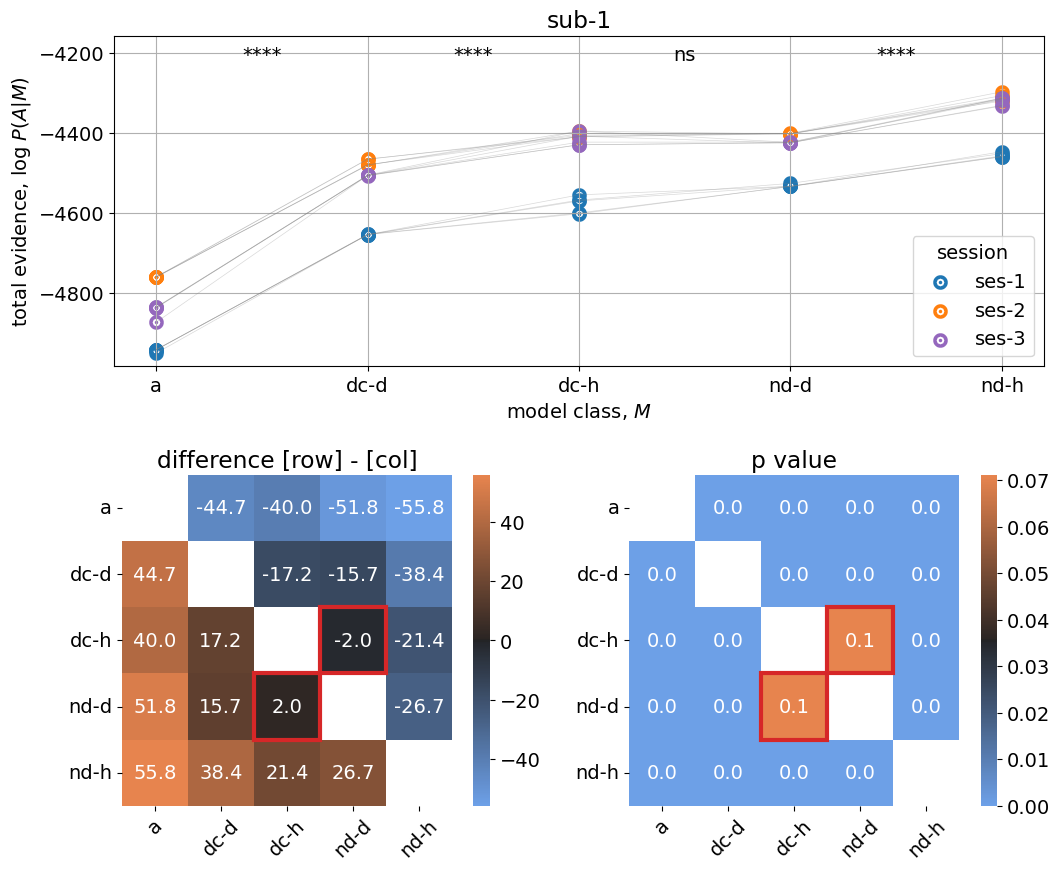

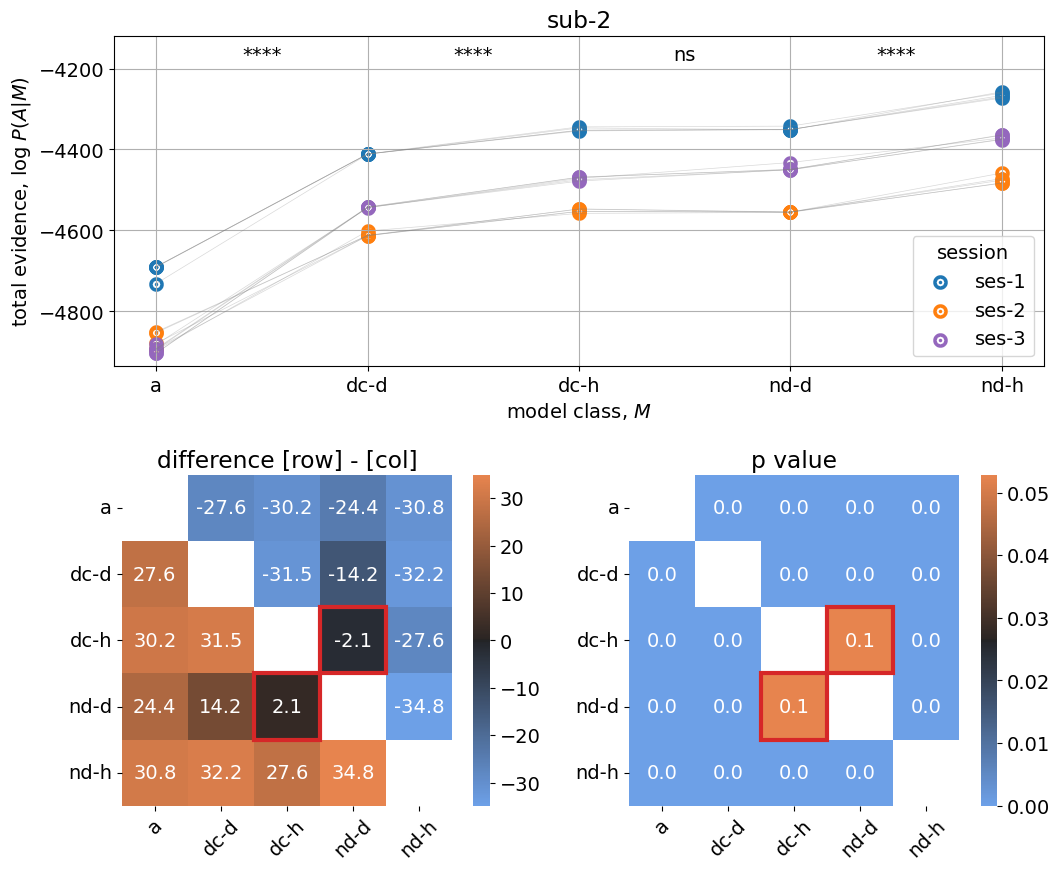

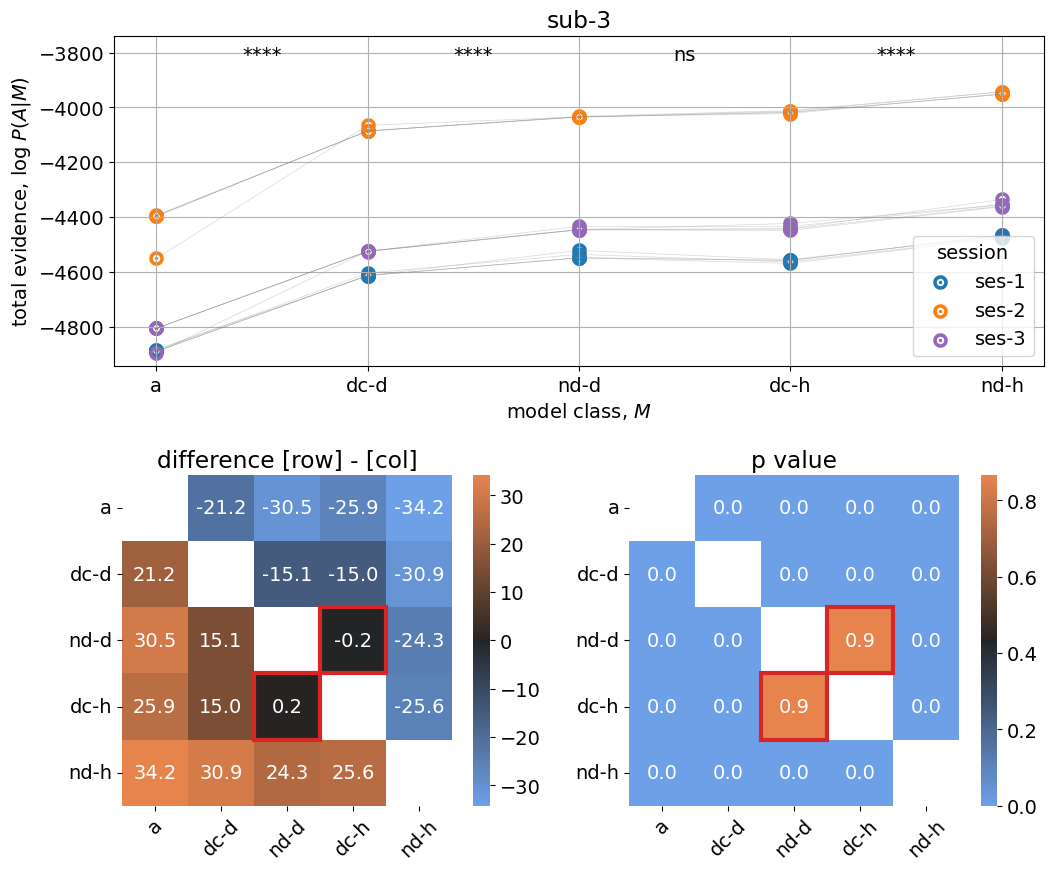

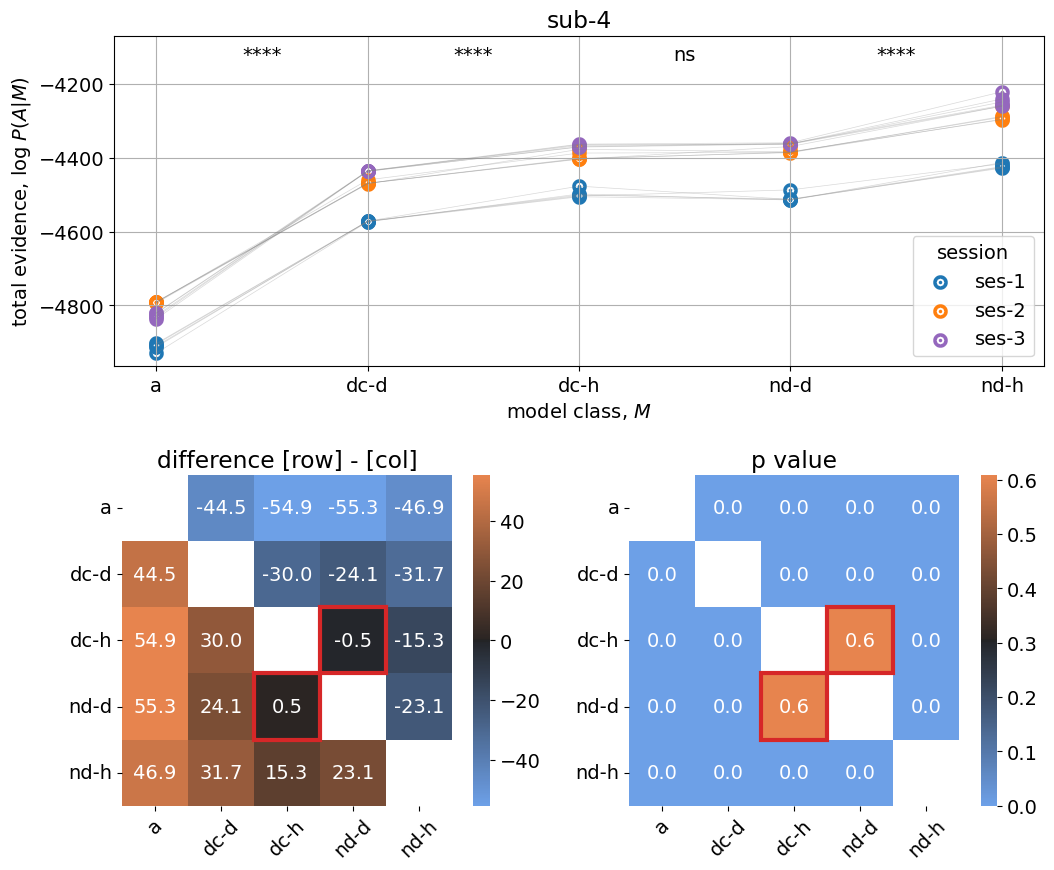

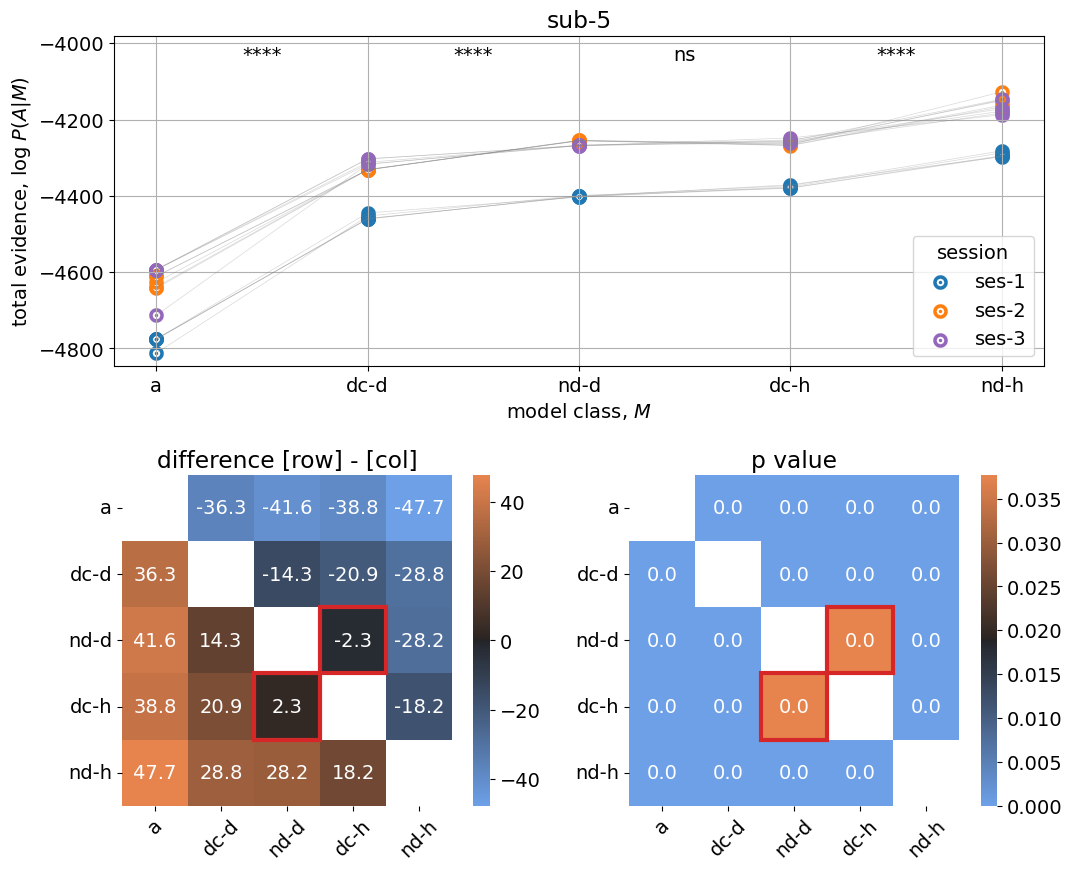

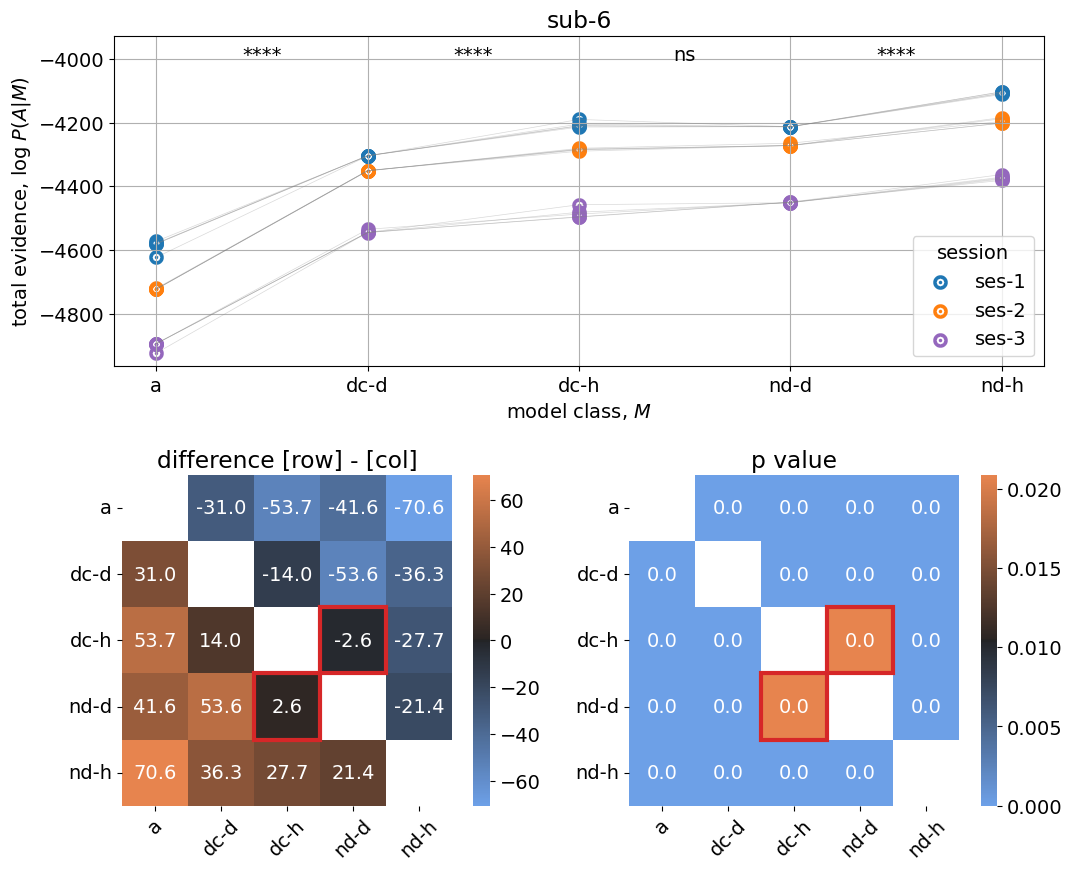

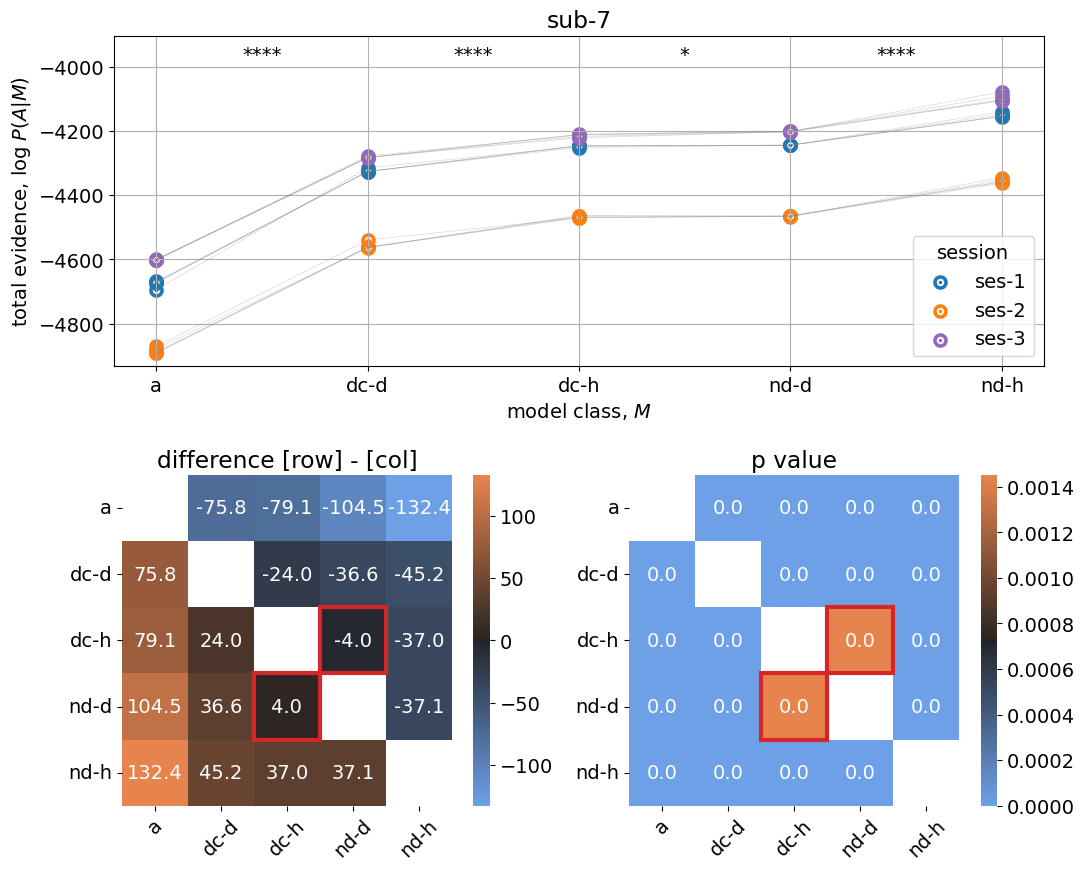

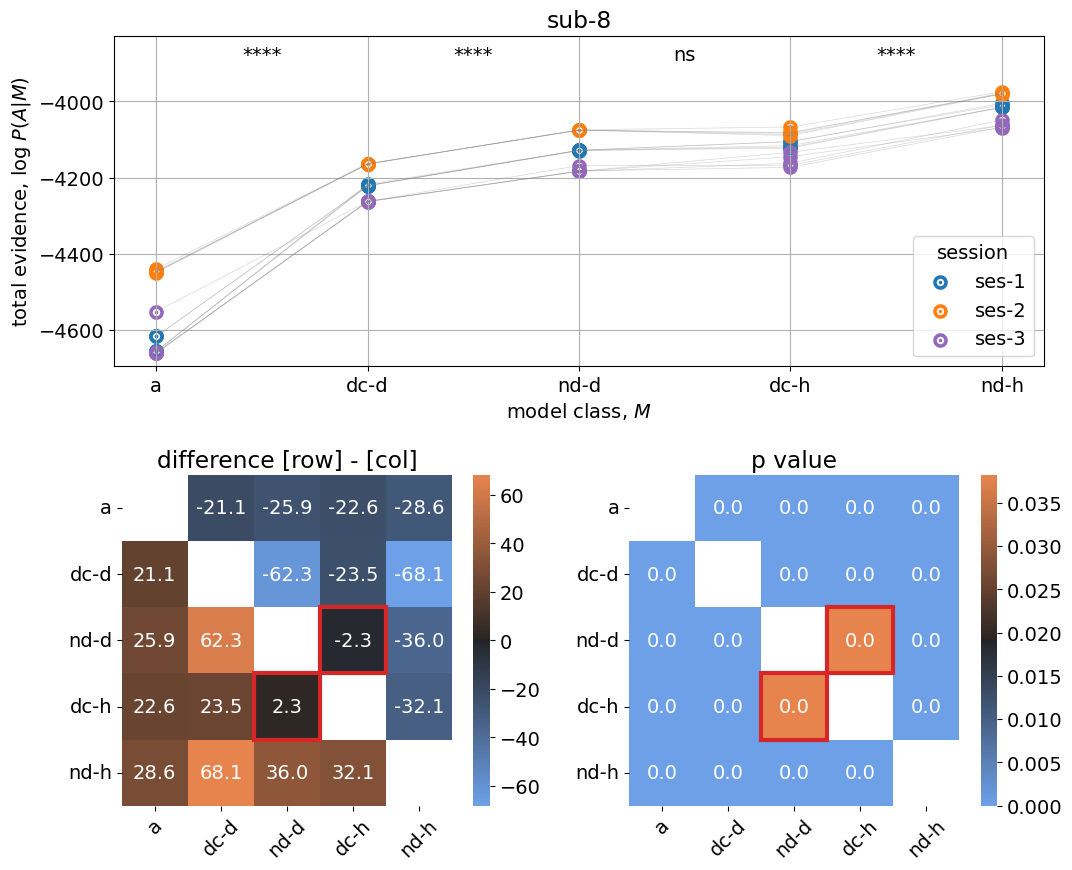

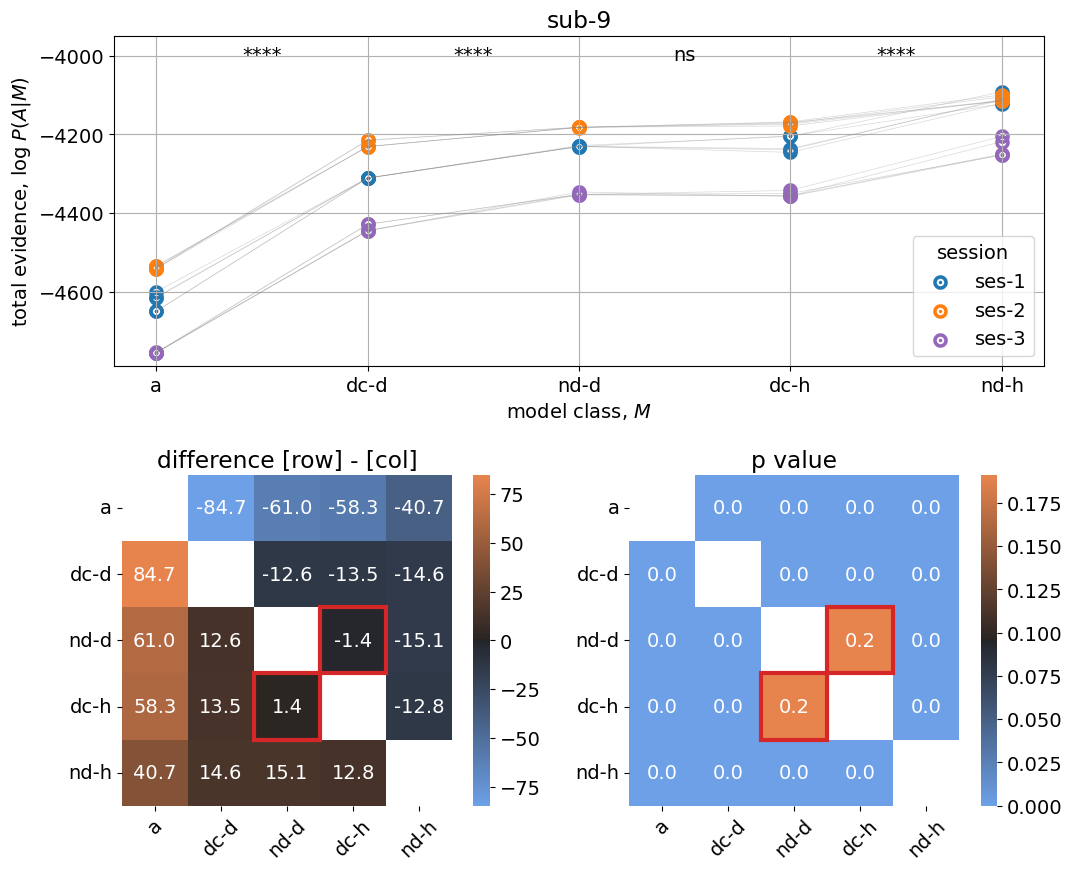

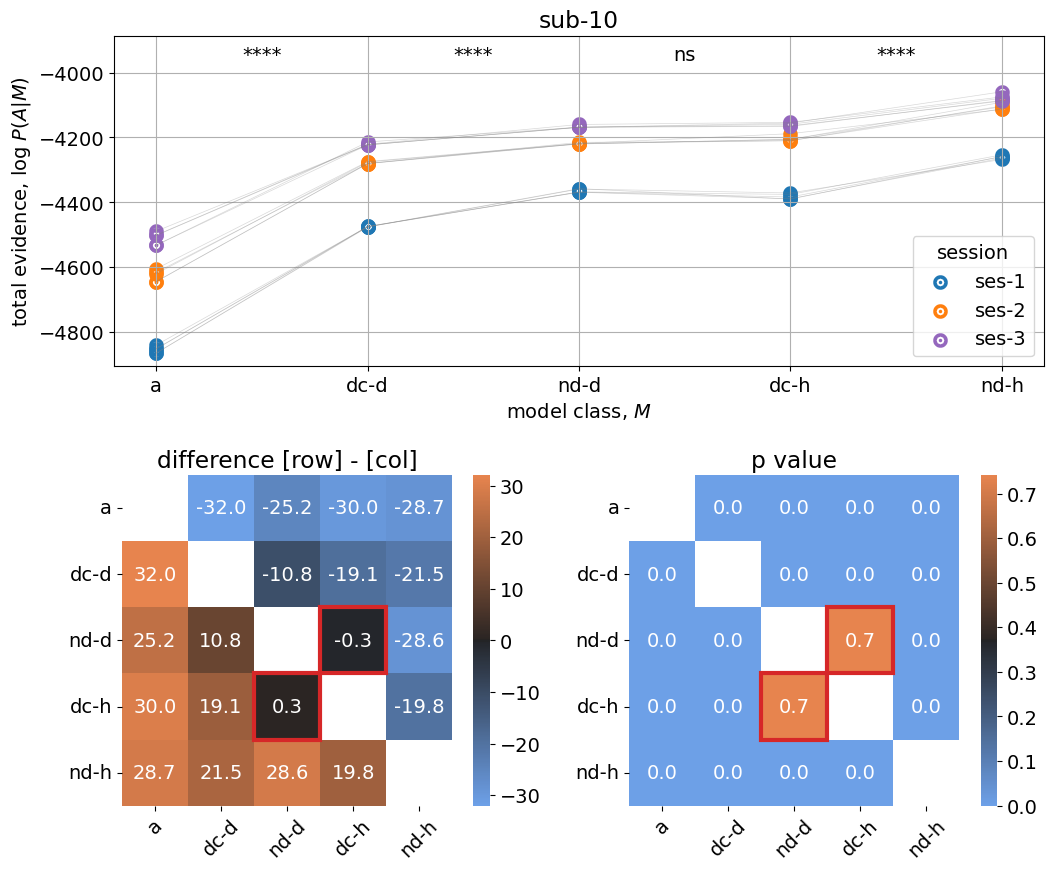

In [7]:
for sub in tqdm(np.arange(1, 11, 1)):
    fits_df, fig = model_comparison(args, sub)